<h2><center>BORN AGAIN NETWORKS ON MULTICLASS CLASSIFICATION</center></h2>

In this notebook we are going to test a Wide Residual Network on a Multiclass  classification dataset from kaggle, it represents 225 different species of birds, the idea is to look how KD performs with an high number of classes


In [ ]:
#Import of all needed packages
import tensorflow as tf
from BANEnsemble import BANEnsemble
from WideResNet import WideResidualNetwork
from knowledge_distillation import *

Let's mount google drive in order to import the dataset, that comes from kaggle at the link [225 Bird species](https://www.kaggle.com/gpiosenka/100-bird-species). And then unzip the file

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
! unzip /content/drive/My\ Drive/datasets/bird_species.zip 

In this step I'm going to do image augmenting, without being too invasive. Fortunately the chosen dataset already includes 3 different data, so I'll just create the train, validation and test generators. Just to have an acceptable training_time, the images are resized.

In [ ]:
# DATA AUGMENTATION, in this case, to speed up the train, the images are resized

BATCH_SIZE = 32
IMAGE_SIZE = (96, 96)
data_path = '/content'

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rotation_range=0.05        )  
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    )

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
train_generator = train_datagen.flow_from_directory(
        data_path+'/train',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        )
validation_generator = valid_datagen.flow_from_directory(
        data_path+'/valid',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        )
test_generator = test_datagen.flow_from_directory(
        data_path+'/test',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 31316 images belonging to 225 classes.
Found 1125 images belonging to 225 classes.
Found 1125 images belonging to 225 classes.


In [ ]:
bird_labels = list(train_generator.class_indices.keys())

Now we can use pyplot just to have an idea of how images appear, after that I built a teacher model using a WideResNet with 1.5M of trainable parameters, compiled with an Adam optimizer.


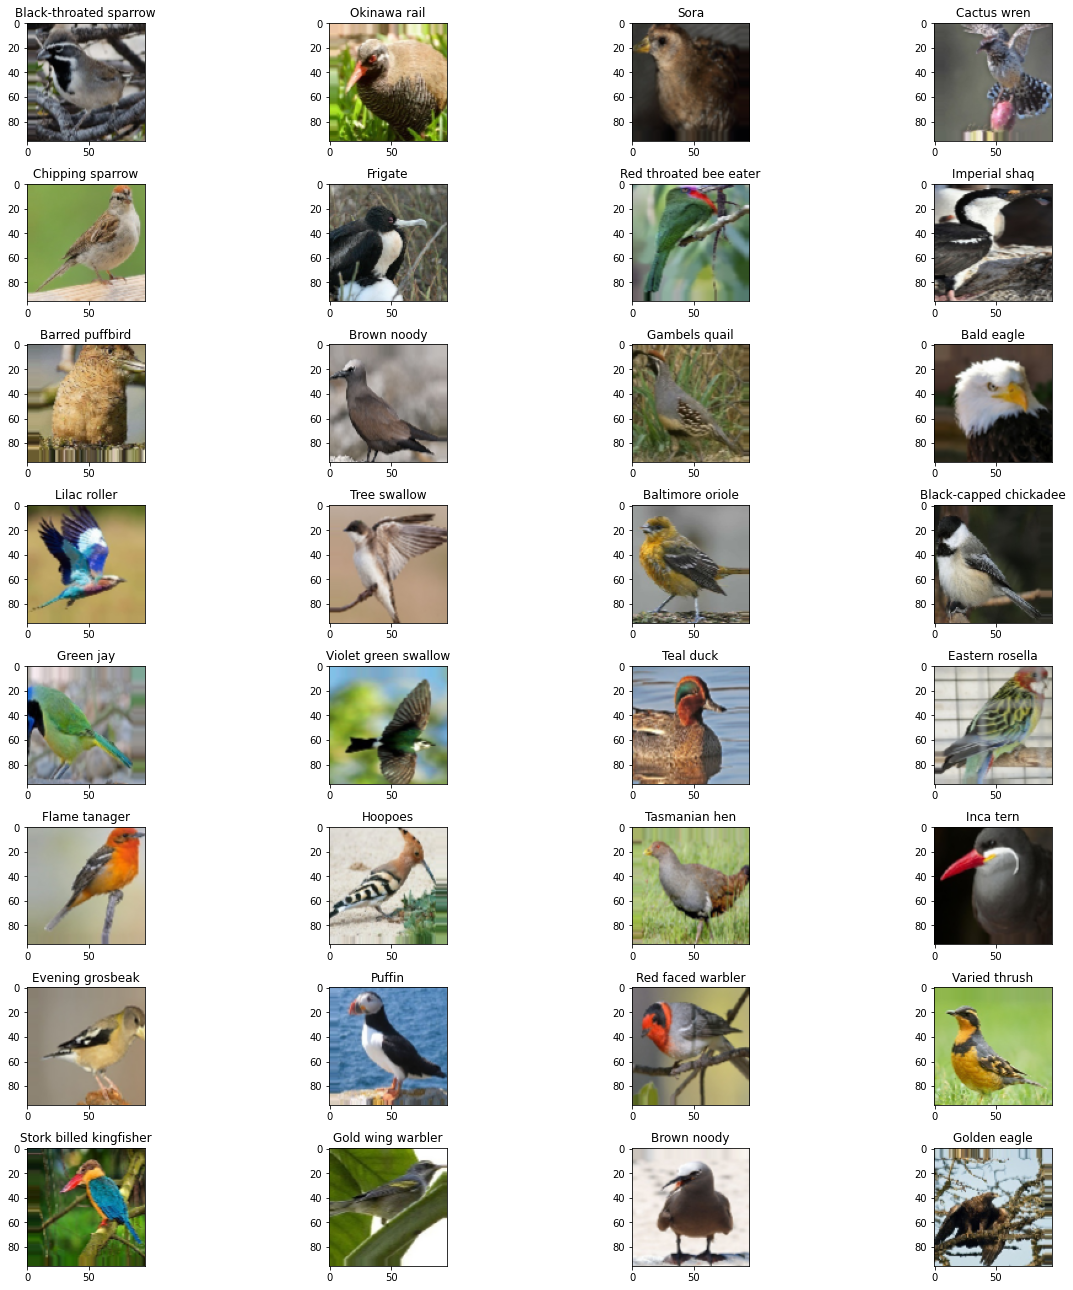

In [ ]:
import matplotlib.pyplot as plt
ROWS = 8
COLUMNS = 4
FIGSIZE = (6, 6)

images, labels = train_generator.next()




fig, ax = plt.subplots(nrows=ROWS, ncols=COLUMNS,figsize=(18, 18))
# plot simple raster image on each sub-plot
for (i, axi), (image, label) in zip(enumerate(ax.flat), zip(images, labels)):

    axi.imshow(image)

    bird_label = bird_labels[tf.argmax(label)]
    axi.set_title(str(bird_label).capitalize())


plt.tight_layout(True)
plt.show()

In [ ]:
# Building of the teacher model
teacher_model = tf.keras.models.Sequential([
                                            WideResidualNetwork(225, 28, 2, includeActivation=False),
                                            tf.keras.layers.Activation('softmax')
])


In [ ]:
# Compiling the model
optimizer_sgd = tf.keras.optimizers.SGD()
teacher_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
teacher_model.build(input_shape=(None, 96, 96, 3))
teacher_model.load_weights('/content/teacher.h5')

In [ ]:
# Callbacks definition and model training
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
rop_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.001, patience=5) # Useful in case of SGD
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('teacher.h5', save_best_only=True, save_weights_only=True)
history = teacher_model.fit(train_generator, callbacks=[es_callback, checkpoint_callback], 
                            steps_per_epoch=train_generator.samples//BATCH_SIZE, 
                            validation_data=test_generator, 
                            validation_steps=test_generator.samples//BATCH_SIZE, epochs=150)

In [ ]:
teacher_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
wide_residual_network (WideR (None, 225)               1505165   
_________________________________________________________________
activation_1 (Activation)    (None, 225)               0         
Total params: 1,505,165
Trainable params: 1,501,767
Non-trainable params: 3,398
_________________________________________________________________


In [ ]:
teacher_model.save_weights('teacher_model.h5')

In [ ]:
teacher_model.evaluate(test_generator)

36/36 [==============================] - 2s 53ms/step - loss: 0.2241 - accuracy: 0.9280


[0.22405380010604858, 0.9279999732971191]

In [ ]:
ban_1 = tf.keras.models.Sequential([
                                            WideResidualNetwork(225, 28, 2, includeActivation=False),
                                            tf.keras.layers.Activation('softmax')
])
ban_1.build(input_shape=(None, 96, 96, 3))
ban_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ban_1.load_weights('ban-1.h5')

In [ ]:
ban_1.evaluate(test_generator)

36/36 [==============================] - 2s 51ms/step - loss: 0.1955 - accuracy: 0.9511


[0.19545690715312958, 0.9511111378669739]

In [ ]:
build_student = lambda : tf.keras.models.Sequential([
                                            WideResidualNetwork(225, 28, 1, includeActivation=False),
                                            tf.keras.layers.Activation('softmax')
])
student_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

## Knowledge Distillation

In this notebook we are going to train the single students, because of limitations of the colab notebook, so that we can follow step by step the procedure.

In [ ]:

student_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True),
                     tf.keras.callbacks.ModelCheckpoint('ban-1.h5', save_best_only=True, save_weights_only=True, monitor='loss')]
distil_knowledge(teacher_model, ban_1, train_generator, validation_generator, student_callbacks, 100, BATCH_SIZE,
                  train_generator.samples//BATCH_SIZE, validation_generator.samples//BATCH_SIZE)

Epoch 1/100
978/978 [==============================] - 210s 214ms/step - loss: 0.4194 - accuracy: 0.9178 - val_loss: 0.4163 - val_accuracy: 0.8920
Epoch 2/100
978/978 [==============================] - 210s 215ms/step - loss: 0.4141 - accuracy: 0.9188 - val_loss: 0.4112 - val_accuracy: 0.8902
Epoch 3/100
978/978 [==============================] - 210s 214ms/step - loss: 0.4169 - accuracy: 0.9180 - val_loss: 0.4206 - val_accuracy: 0.8911
Epoch 4/100
978/978 [==============================] - 209s 214ms/step - loss: 0.4148 - accuracy: 0.9196 - val_loss: 0.4041 - val_accuracy: 0.8973
Epoch 5/100
978/978 [==============================] - 209s 214ms/step - loss: 0.4083 - accuracy: 0.9206 - val_loss: 0.3385 - val_accuracy: 0.8955
Epoch 6/100
978/978 [==============================] - 209s 214ms/step - loss: 0.4113 - accuracy: 0.9198 - val_loss: 0.4534 - val_accuracy: 0.8938
Epoch 7/100
978/978 [==============================] - 209s 214ms/step - loss: 0.3988 - accuracy: 0.9233 - val_loss: 0

In [ ]:
ban_1.evaluate(test_generator)

36/36 [==============================] - 2s 49ms/step - loss: 0.1955 - accuracy: 0.9511


[0.19545692205429077, 0.9511111378669739]

In [ ]:
ban_2 = tf.keras.models.Sequential([
                                            WideResidualNetwork(225, 28, 2, includeActivation=False),
                                            tf.keras.layers.Activation('softmax')
])
ban_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
student_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True),
                     tf.keras.callbacks.ModelCheckpoint('ban-2.h5', save_best_only=True, save_weights_only=True, monitor='loss')]
history = distil_knowledge(ban_1, ban_2, train_generator, validation_generator, student_callbacks, 100, BATCH_SIZE,
                  train_generator.samples//BATCH_SIZE, validation_generator.samples//BATCH_SIZE)

Epoch 1/100
978/978 [==============================] - 208s 213ms/step - loss: 5.0235 - accuracy: 0.0351 - val_loss: 4.6546 - val_accuracy: 0.0589
Epoch 2/100
978/978 [==============================] - 208s 213ms/step - loss: 4.3125 - accuracy: 0.1015 - val_loss: 3.9667 - val_accuracy: 0.1437
Epoch 3/100
978/978 [==============================] - 207s 212ms/step - loss: 3.6546 - accuracy: 0.1948 - val_loss: 3.3221 - val_accuracy: 0.2438
Epoch 4/100
978/978 [==============================] - 206s 211ms/step - loss: 3.0191 - accuracy: 0.3168 - val_loss: 3.0585 - val_accuracy: 0.3018
Epoch 5/100
978/978 [==============================] - 206s 211ms/step - loss: 2.4858 - accuracy: 0.4279 - val_loss: 1.9521 - val_accuracy: 0.5134
Epoch 6/100
978/978 [==============================] - 207s 212ms/step - loss: 2.0825 - accuracy: 0.5179 - val_loss: 1.8289 - val_accuracy: 0.5366
Epoch 7/100
978/978 [==============================] - 207s 212ms/step - loss: 1.7821 - accuracy: 0.5884 - val_loss: 1

In [ ]:
compile_args={'optimizer':'adam', 
                      'loss': 'categorical_crossentropy', 
                      'metrics': ['accuracy']}

In [ ]:
ban_3 = tf.keras.models.Sequential([
                                            WideResidualNetwork(225, 28, 2, includeActivation=False),
                                            tf.keras.layers.Activation('softmax')
])
ban_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
student_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True),
                     tf.keras.callbacks.ModelCheckpoint('ban-3.h5', save_best_only=True, save_weights_only=True, monitor='loss')]
history = distil_knowledge(ban_2, ban_3, train_generator, validation_generator, student_callbacks, 100, BATCH_SIZE,
                  train_generator.samples//BATCH_SIZE, validation_generator.samples//BATCH_SIZE)

Epoch 1/100
978/978 [==============================] - 217s 222ms/step - loss: 1.3053 - accuracy: 0.7406 - val_loss: 0.8486 - val_accuracy: 0.7723
Epoch 2/100
978/978 [==============================] - 216s 221ms/step - loss: 1.2551 - accuracy: 0.7590 - val_loss: 0.8433 - val_accuracy: 0.7804
Epoch 3/100
978/978 [==============================] - 214s 219ms/step - loss: 1.1938 - accuracy: 0.7751 - val_loss: 0.9774 - val_accuracy: 0.7500
Epoch 4/100
978/978 [==============================] - 219s 224ms/step - loss: 1.1445 - accuracy: 0.7898 - val_loss: 0.7934 - val_accuracy: 0.7741
Epoch 5/100
978/978 [==============================] - 217s 222ms/step - loss: 1.1114 - accuracy: 0.8007 - val_loss: 0.6793 - val_accuracy: 0.8071
Epoch 6/100
978/978 [==============================] - 218s 223ms/step - loss: 1.0793 - accuracy: 0.8123 - val_loss: 1.1949 - val_accuracy: 0.7241
Epoch 7/100
978/978 [==============================] - 218s 223ms/step - loss: 1.0571 - accuracy: 0.8205 - val_loss: 0

In [ ]:
ban_3.evaluate(test_generator)

36/36 [==============================] - 2s 54ms/step - loss: 0.3558 - accuracy: 0.8987


[0.3557840585708618, 0.8986666798591614]

In [ ]:
ensemble = BANEnsemble(students)
ensemble.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ensemble.evaluate(test_generator)

36/36 [==============================] - 7s 201ms/step - loss: 0.1819 - accuracy: 0.9573


[0.18192368745803833, 0.9573333263397217]